In [2]:
%load_ext autoreload
%autoreload 2

import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

from pymfr.detect import detect_flux_ropes
from pymfr.reconstruct import reconstruct_map


In [3]:
torch.cuda.device_count()

1

In [4]:
time = ['2016-01-01T00:00:00Z', '2016-02-01T00:00:00Z']

file_name = f"./data/wind_{time[0]}_{time[1]}_1min_nonlin.npz".replace(':', '-')
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('WI_H1_SWE', ['Proton_VX_nonlin',
                                               'Proton_VY_nonlin',
                                               'Proton_VZ_nonlin',
                                               'Proton_Np_nonlin',
                                               'Proton_W_nonlin'],
                                 time[0], time[1])

    datetime = data.Epoch.values

    velocity = np.column_stack([data.Proton_VX_nonlin.values,
                                data.Proton_VY_nonlin.values,
                                data.Proton_VZ_nonlin.values])
    velocity[np.any(velocity == data.Proton_VX_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VY_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VZ_nonlin.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime)).interpolate()
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s").interpolate()
    times = velocity.index.values

    density = data.Proton_Np_nonlin.values
    density[density == data.Proton_Np_nonlin.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime)).interpolate()
    density = density.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    temperature = data.Proton_W_nonlin.values
    temperature[temperature == data.Proton_W_nonlin.FILLVAL] = np.nan
    temperature = (temperature * 1e3) ** 2 * scipy.constants.m_p / (2 * scipy.constants.Boltzmann) / 1e6
    temperature = pd.Series(temperature, index=pd.DatetimeIndex(datetime)).interpolate()
    temperature = temperature.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    status, data = cdas.get_data('WI_H0_MFI', ['BGSE'], time[0], time[1])

    magnetic_field = data.BGSE.values
    magnetic_field[np.any(magnetic_field == data.BGSE.FILLVAL, axis=1), :] = np.nan
    datetime = data.Epoch.values
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime)).interpolate()

    magnetic_field = magnetic_field.truncate(times[0], times[-1])
    density = density.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    temperature = temperature.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    
    velocity = velocity.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    times = magnetic_field.index.values

    assert len(magnetic_field) == len(velocity) == len(density)

    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, temperature=temperature, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
temperature = torch.as_tensor(data["temperature"], dtype=torch.float32)
times = data["times"]

In [8]:
window_lengths = range(10, 360)

gas_pressure = scipy.constants.Boltzmann * (density * 1e6) * (temperature * 1e6) * 1e9

results = detect_flux_ropes(magnetic_field, velocity, density, gas_pressure,
                            batch_size=10000,
                            window_steps=[1] * len(window_lengths),
                            window_lengths=window_lengths,
                            sample_spacing=60,
                            n_trial_axes=256,
                            threshold_diff=0.3,
                            threshold_fit=0.3,
                            max_processing_resolution=32,
                            cuda=True)



100%|██████████| 350/350 [00:32<00:00, 10.89it/s]


In [9]:
len(results.event)

258

2016-01-01T06:16:30.000000000  to  2016-01-01T06:56:30.000000000
window length: 40
duration: 40.0
error: 0.281 0.122
walen slope: -0.296
alfvenicity: -0.311
<B>: 10.88
Altitude/azimuth: 153 / 295
Frame quality: 0.9999404549598694
Field alignment -0.9431278705596924


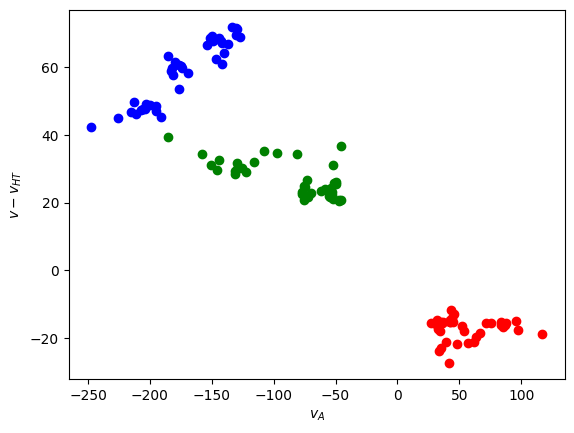

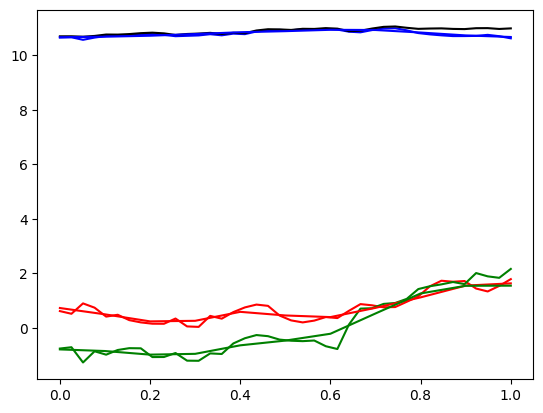

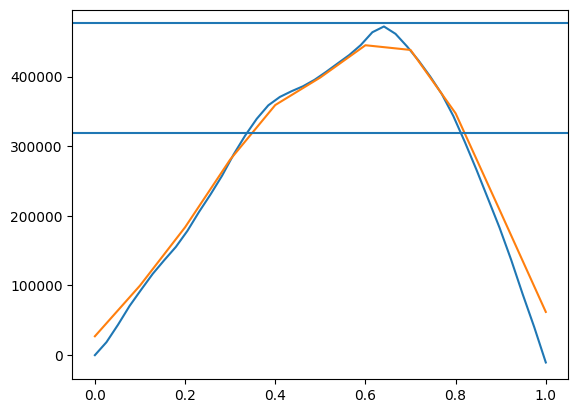

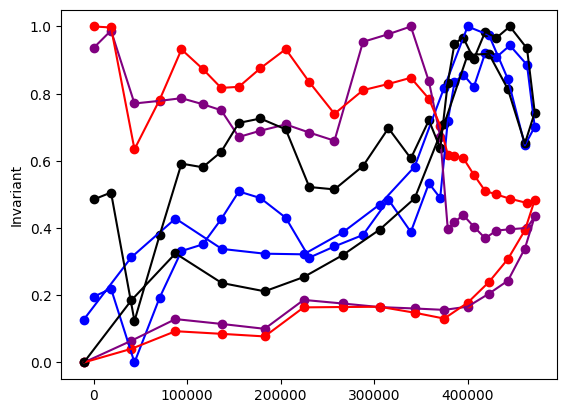

closed % 17
width 0.4
height 0.3333333333333333
poloidal flux per au 23800.856250000004
axial flux 147.05285529600002
twist per au 161.85239111536933
field line length 0.006178469116883137
<xarray.DataArray 'spatial_scale' ()>
array(0.00676868)
scale in au 0.0007754493399341015


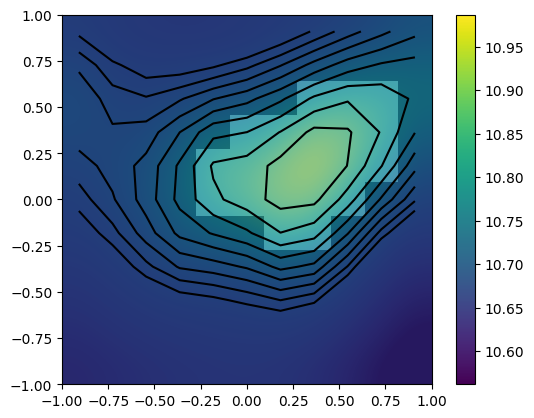

2016-01-01T07:51:30.000000000  to  2016-01-01T11:46:30.000000000
window length: 235
duration: 235.0
error: 0.152 0.076
walen slope: -0.08
alfvenicity: -0.087
<B>: 9.74
Altitude/azimuth: 83 / 287
Frame quality: 0.9987991452217102
Field alignment -0.672161340713501


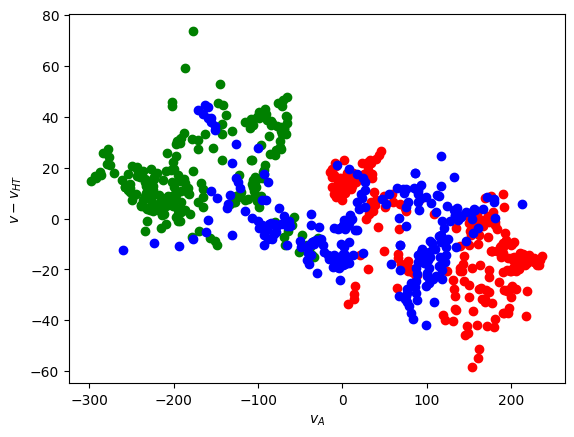

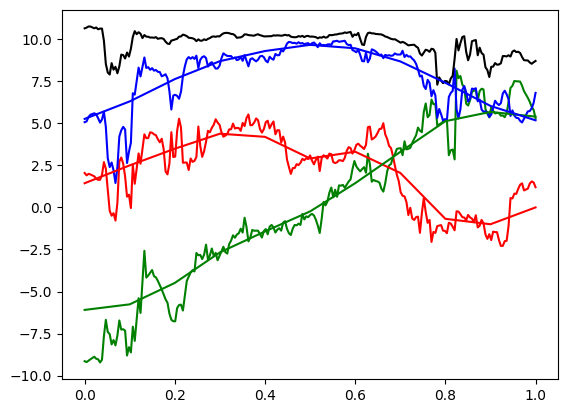

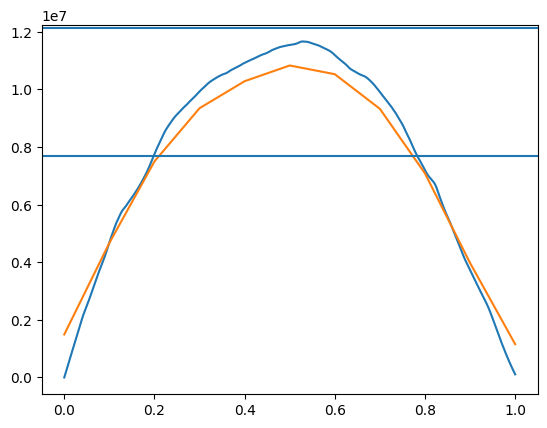

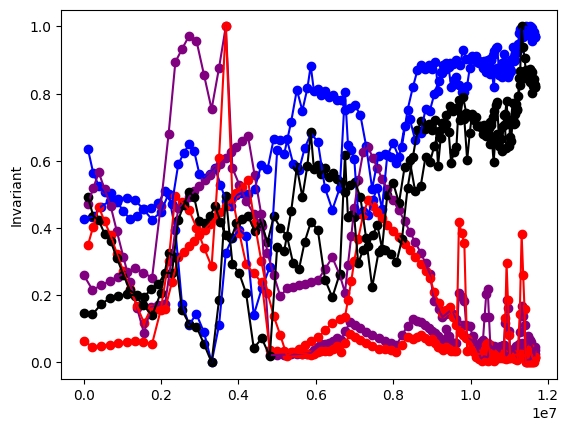

closed % 25
width 0.4
height 0.4
poloidal flux per au 666150.0750000001
axial flux 169.95498393600002
twist per au 3919.567755958556
field line length 0.0002551301730859972
<xarray.DataArray 'spatial_scale' ()>
array(0.03820494)
scale in au 0.0009051748055394352


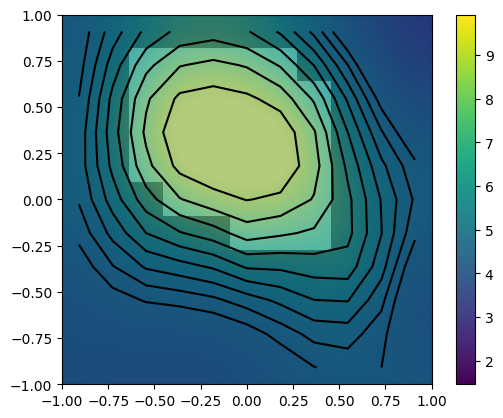

2016-01-01T11:59:30.000000000  to  2016-01-01T12:49:30.000000000
window length: 50
duration: 50.0
error: 0.143 0.23
walen slope: 0.363
alfvenicity: 0.365
<B>: 9.75
Altitude/azimuth: 104 / 318
Frame quality: 0.998896062374115
Field alignment 0.9453634023666382


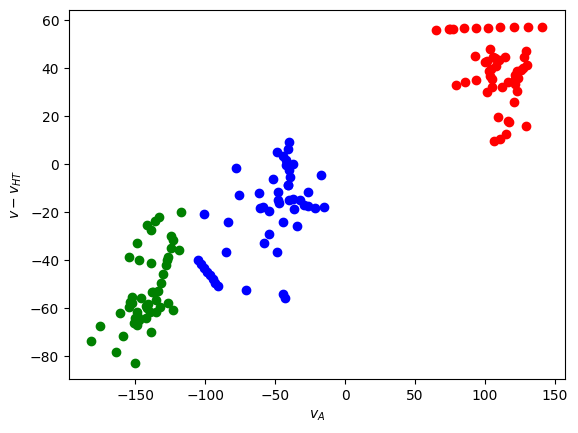

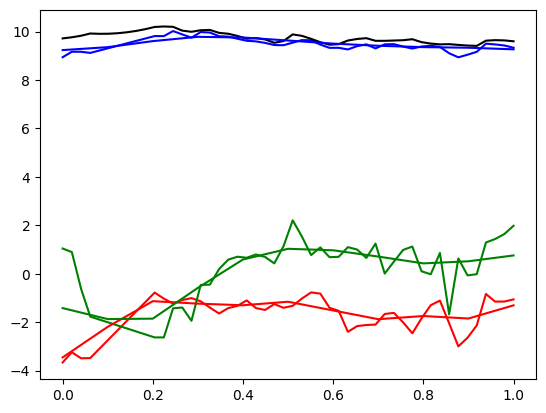

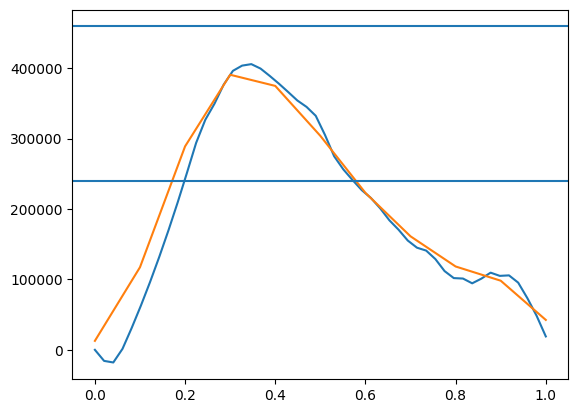

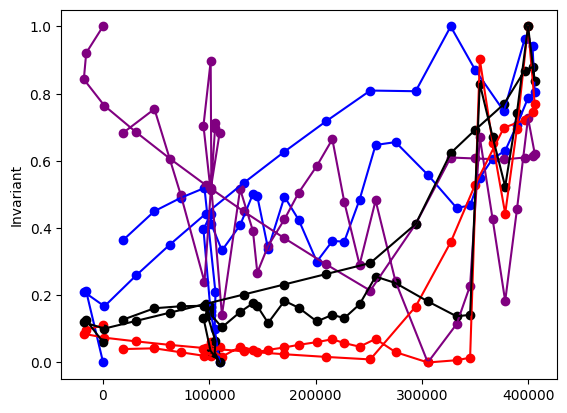

closed % 17
width 0.4
height 0.3333333333333333
poloidal flux per au 32998.6265625
axial flux 53.486350336
twist per au 616.9541641036152
field line length 0.0016208659543661878
<xarray.DataArray 'spatial_scale' ()>
array(0.0054087)
scale in au 0.000495715426871692


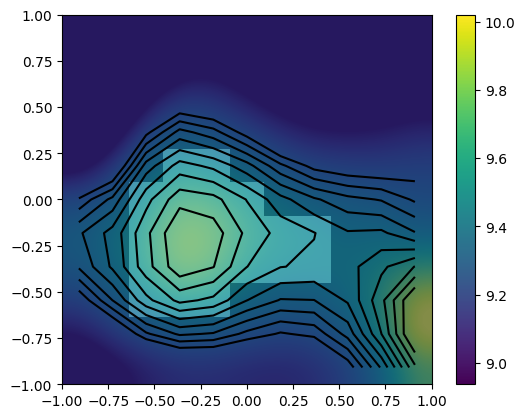

2016-01-01T13:34:30.000000000  to  2016-01-01T13:55:30.000000000
window length: 21
duration: 21.0
error: 0.206 0.168
walen slope: -0.02
alfvenicity: -0.02
<B>: 9.16
Altitude/azimuth: 99 / 317
Frame quality: 0.999914824962616
Field alignment -0.7348183393478394


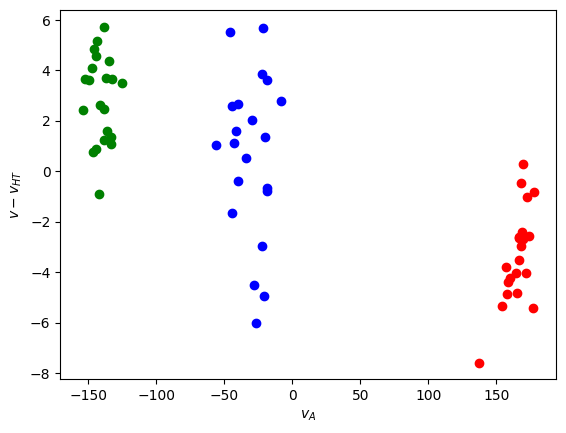

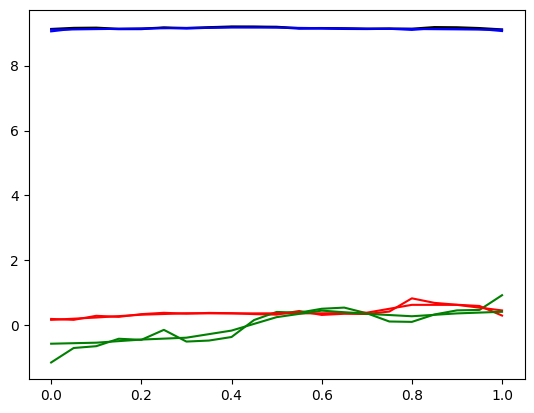

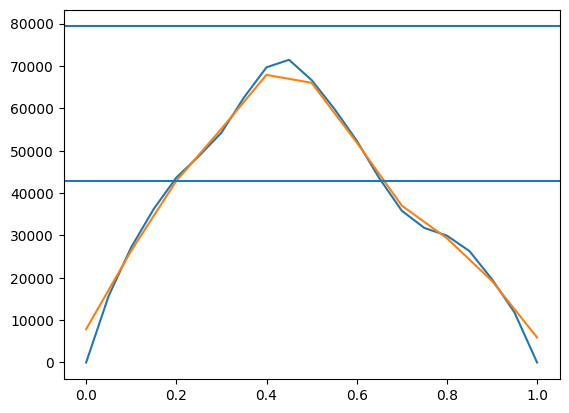

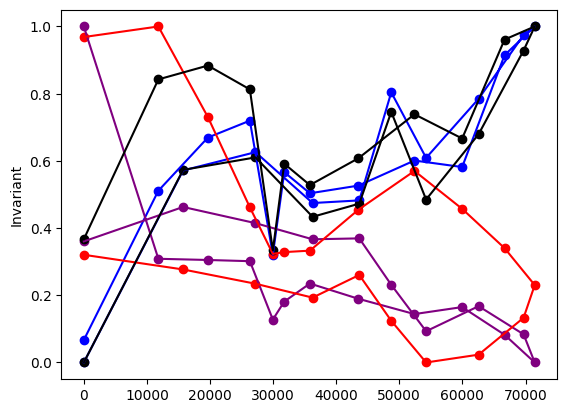

closed % 19
width 0.3333333333333333
height 0.4
poloidal flux per au 5468.162109375
axial flux 60.63878144
twist per au 90.17598935073521
field line length 0.011089426433798776
<xarray.DataArray 'spatial_scale' ()>
array(0.00237462)
scale in au 0.000542299362842931


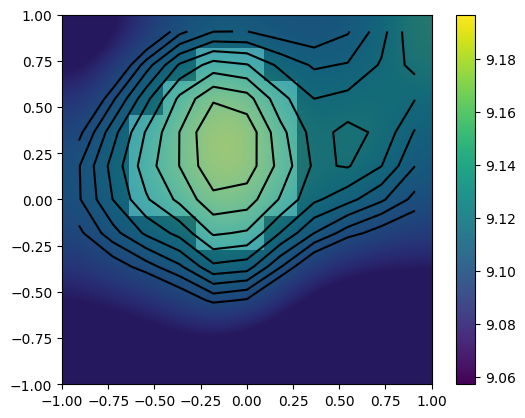

2016-01-01T14:20:30.000000000  to  2016-01-01T16:00:30.000000000
window length: 100
duration: 100.0
error: 0.229 0.189
walen slope: 0.09
alfvenicity: 0.09
<B>: 9.01
Altitude/azimuth: 89 / 308
Frame quality: 0.9997321367263794
Field alignment 0.8686362504959106


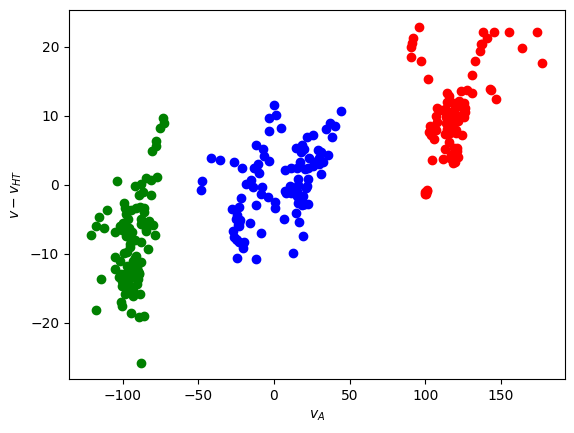

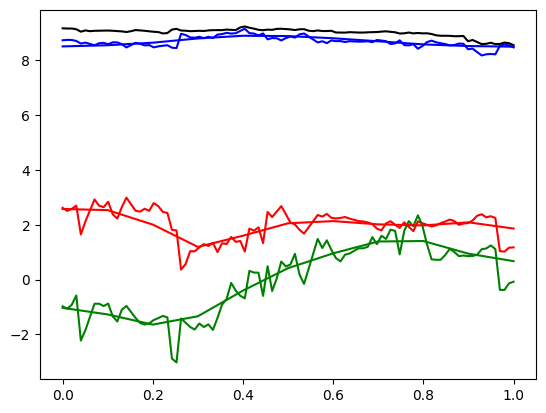

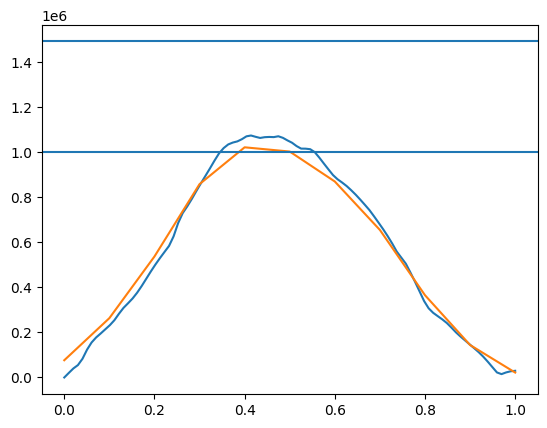

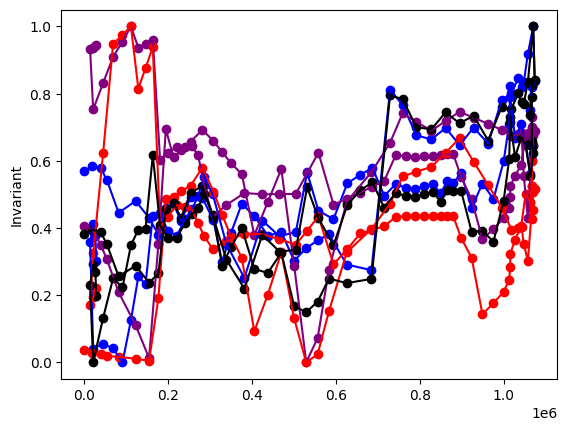

closed % 18
width 0.4
height 0.3333333333333333
poloidal flux per au 73372.98750000002
axial flux 78.96766054400001
twist per au 929.1523516657468
field line length 0.0010762497648606716
<xarray.DataArray 'spatial_scale' ()>
array(0.01329439)
scale in au 0.0006235619182184401


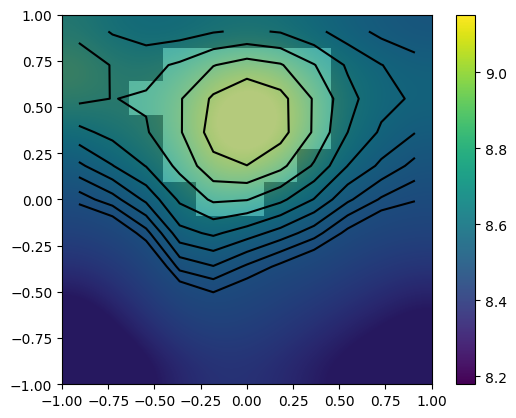

2016-01-01T19:49:30.000000000  to  2016-01-01T21:01:30.000000000
window length: 72
duration: 72.0
error: 0.269 0.225
walen slope: 0.209
alfvenicity: 0.203
<B>: 4.75
Altitude/azimuth: 84 / 357
Frame quality: 0.9994334578514099
Field alignment 0.7647631764411926


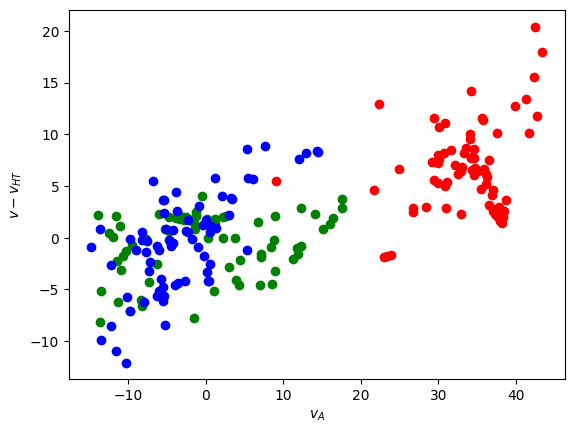

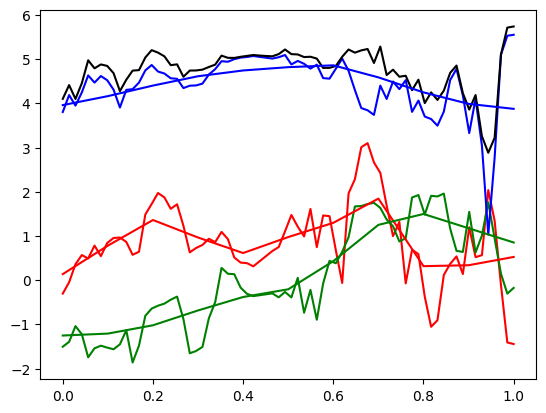

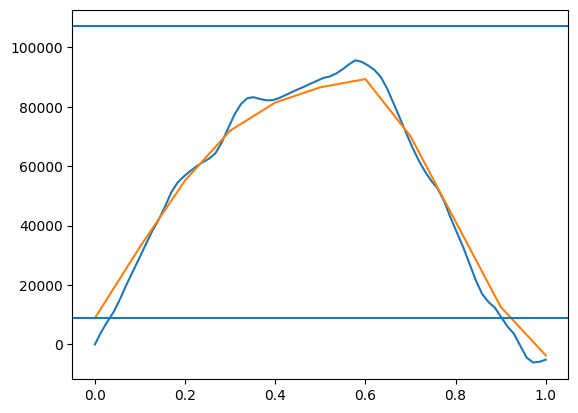

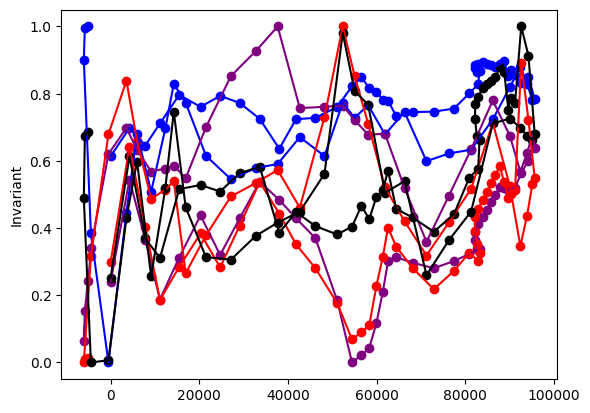

closed % 38
width 0.6
height 0.4666666666666667
poloidal flux per au 14708.792578125
axial flux 1.771517824
twist per au 8302.932309714655
field line length 0.0001204393776437239
<xarray.DataArray 'spatial_scale' ()>
array(0.00140483)
scale in au 0.00013376395158816735


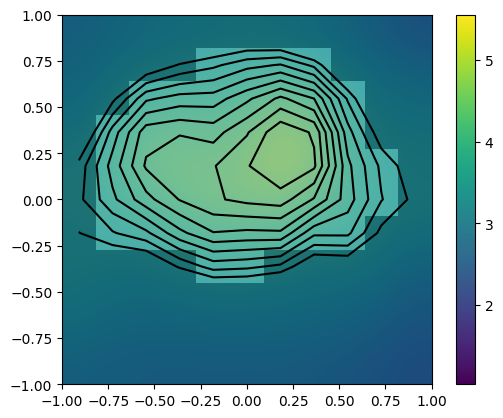

2016-01-02T01:12:30.000000000  to  2016-01-02T03:22:30.000000000
window length: 130
duration: 130.0
error: 0.191 0.164
walen slope: 0.28
alfvenicity: 0.282
<B>: 9.71
Altitude/azimuth: 89 / 304
Frame quality: 0.9998270273208618
Field alignment 0.9845038056373596


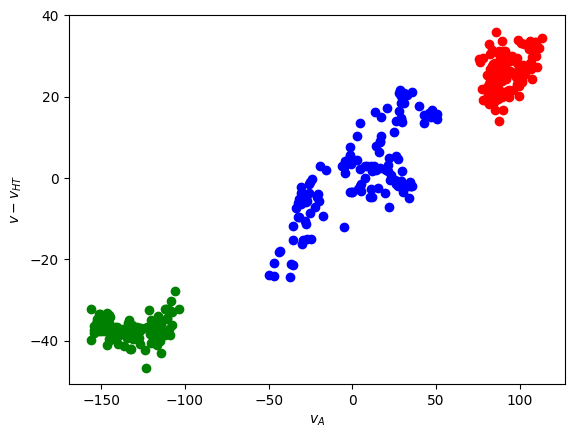

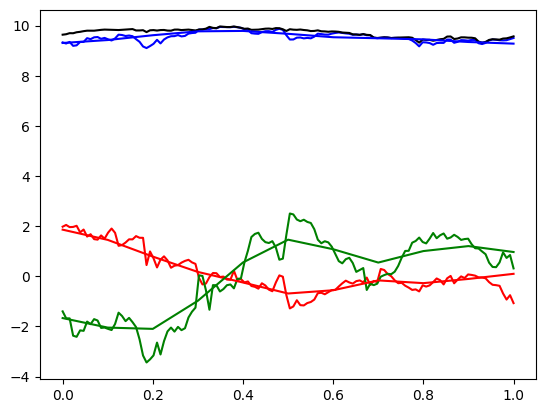

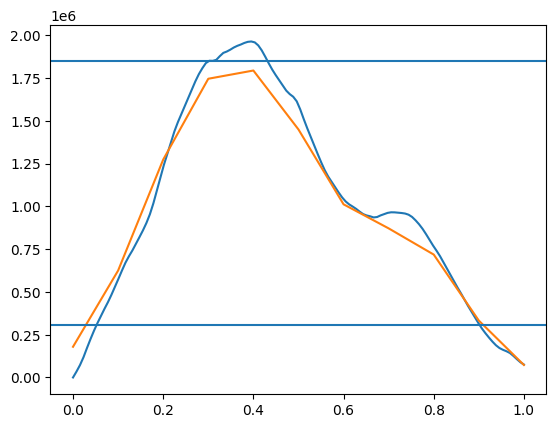

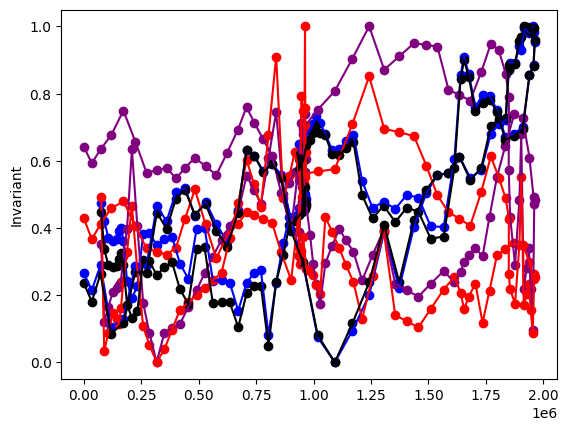

closed % 42
width 0.6
height 0.6
poloidal flux per au 230768.7375
axial flux 254.1838336
twist per au 907.8812536250928
field line length 0.0011014656333161246
<xarray.DataArray 'spatial_scale' ()>
array(0.0196071)
scale in au 0.0010876065318636814


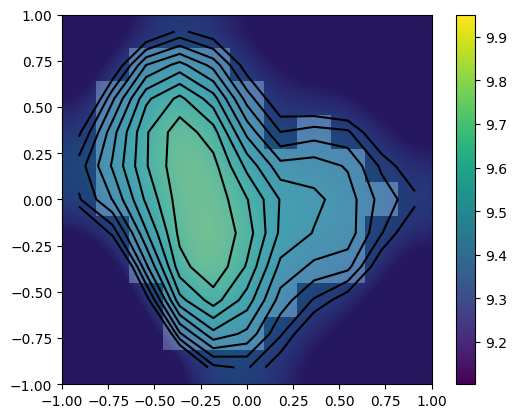

2016-01-02T03:22:30.000000000  to  2016-01-02T04:16:30.000000000
window length: 54
duration: 54.0
error: 0.176 0.167
walen slope: 0.318
alfvenicity: 0.325
<B>: 9.14
Altitude/azimuth: 90 / 357
Frame quality: 0.9986460208892822
Field alignment 0.9573919773101807


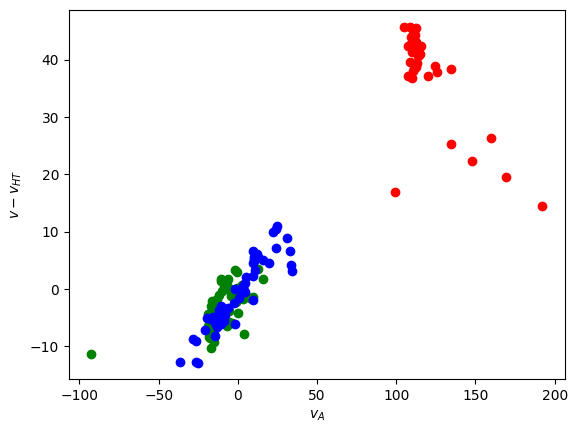

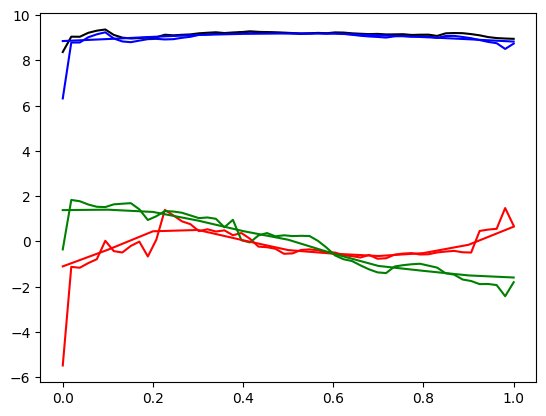

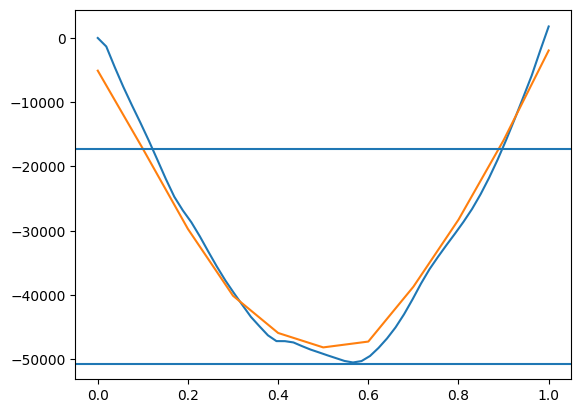

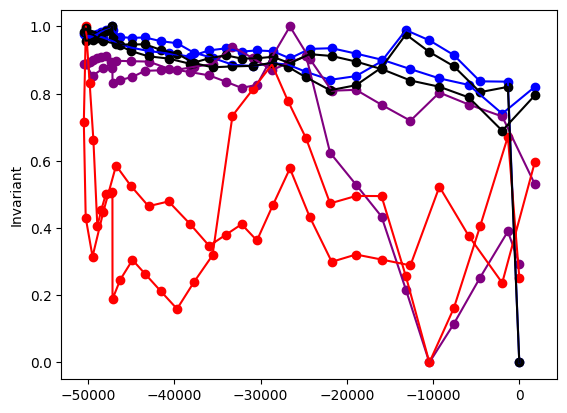

closed % 38
width 0.5333333333333333
height 0.6
poloidal flux per au 5037.486328125
axial flux 1.3642120960000002
twist per au 3692.5976121274616
field line length 0.0002708120691828801
<xarray.DataArray 'spatial_scale' ()>
array(0.00064352)
scale in au 8.169959826327966e-05


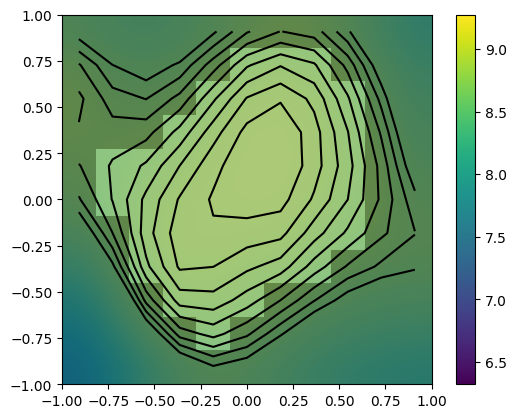

2016-01-02T06:47:30.000000000  to  2016-01-02T07:19:30.000000000
window length: 32
duration: 32.0
error: 0.198 0.101
walen slope: -0.073
alfvenicity: -0.074
<B>: 4.84
Altitude/azimuth: 70 / 296
Frame quality: 0.9999815225601196
Field alignment -0.6176426410675049


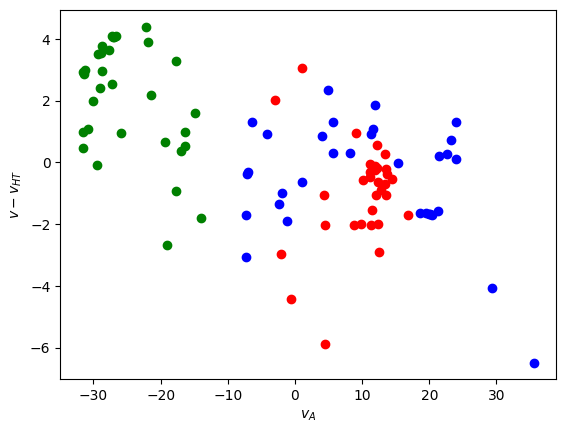

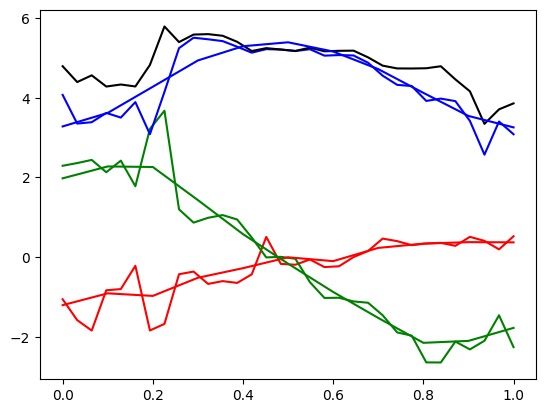

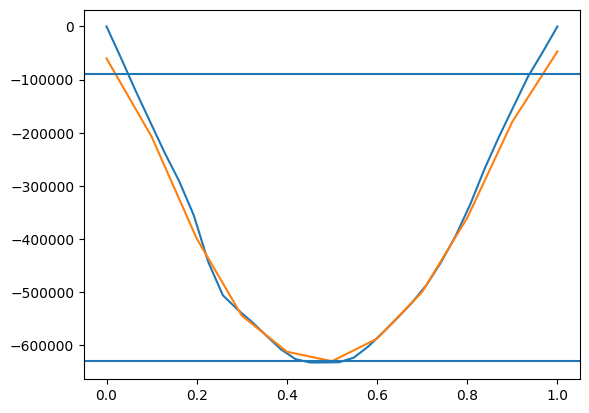

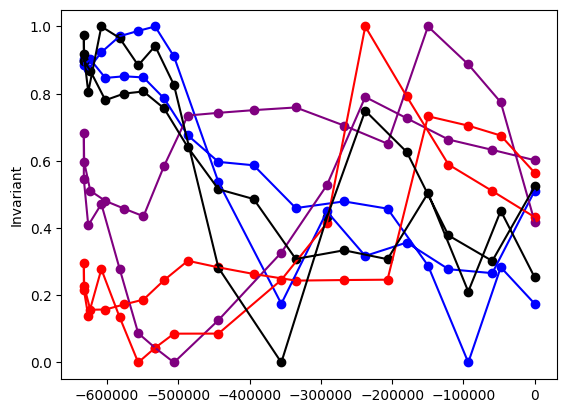

closed % 44
width 0.6
height 0.4666666666666667
poloidal flux per au 81115.9875
axial flux 146.25226752
twist per au 554.6306315483785
field line length 0.0018030017512885483
<xarray.DataArray 'spatial_scale' ()>
array(0.00545858)
scale in au 0.0012535057740817818


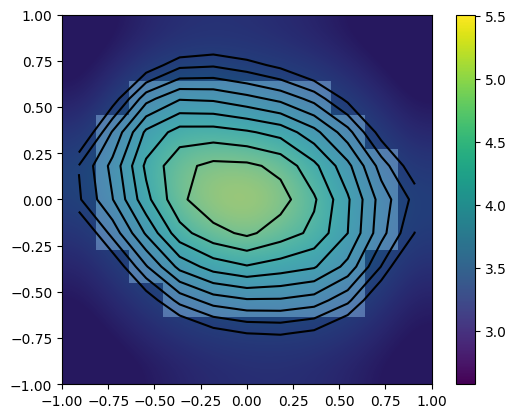

2016-01-02T07:45:30.000000000  to  2016-01-02T08:01:30.000000000
window length: 16
duration: 16.0
error: 0.229 0.197
walen slope: -0.385
alfvenicity: -0.382
<B>: 5.9
Altitude/azimuth: 99 / 316
Frame quality: 0.9998947978019714
Field alignment -0.9276838302612305


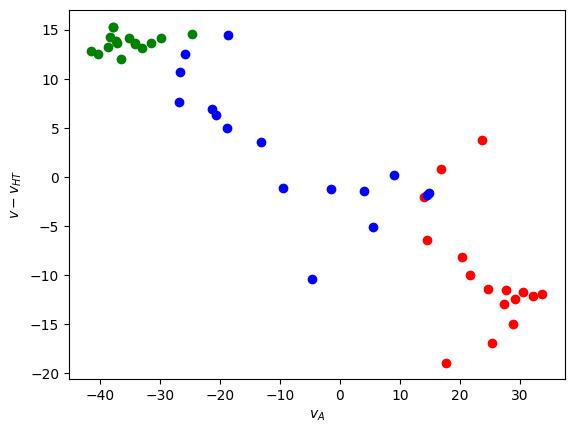

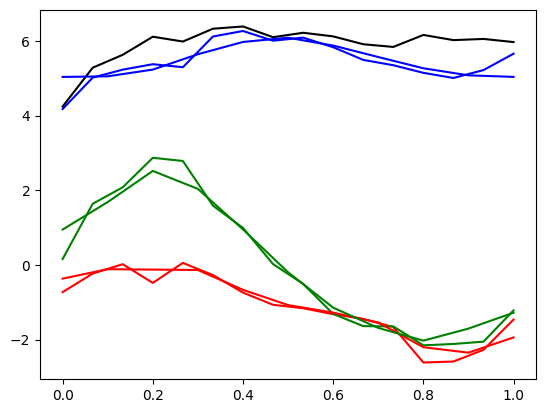

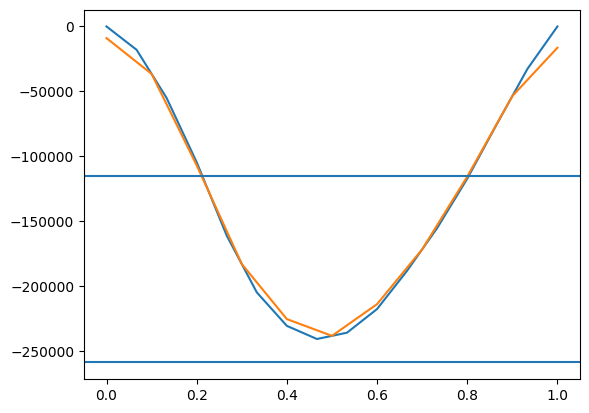

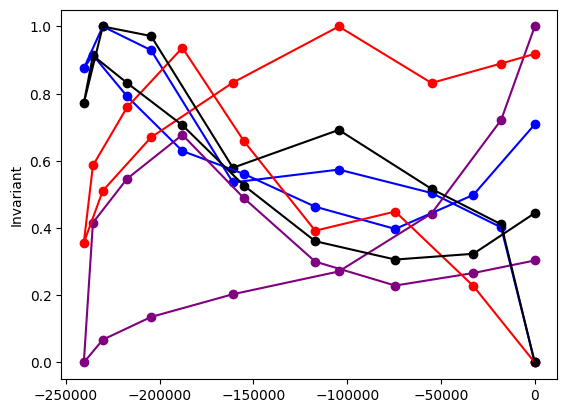

closed % 31
width 0.4666666666666667
height 0.4666666666666667
poloidal flux per au 21530.4234375
axial flux 86.014599168
twist per au 250.3112686190365
field line length 0.003995025895226312
<xarray.DataArray 'spatial_scale' ()>
array(0.00213126)
scale in au 0.0008211231971965285


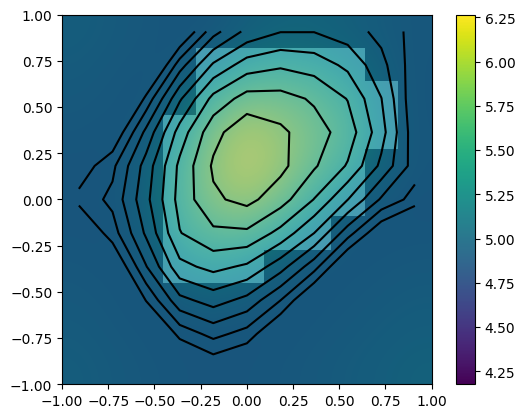

In [10]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


for i_event in list(sorted(results.event, reverse=False, key=lambda x: results.window_start.sel(event=x)))[:10]:
    event = results.sel(event=i_event)
    axis = event[["axis_x", "axis_y", "axis_z"]].to_array().values
    propagation_velocity = event[["velocity_x", "velocity_y", "velocity_z"]].to_array().values
    window_start = event.window_start.item()
    window_length = event.window_length.item()
    temporal_scale = event.temporal_scale.item()
    residue = event.residue_diff.item()
    error_fit = event.residue_fit.item()

    event_flow_velocity = velocity[window_start:window_start + window_length].cpu().numpy()
    event_magnetic_field = magnetic_field[window_start:window_start + window_length].cpu().numpy()
    event_density = density[window_start:window_start + window_length].cpu().numpy()
    Pgas = gas_pressure[window_start:window_start + window_length].cpu().numpy()

    x_unit = -(propagation_velocity - np.dot(propagation_velocity, axis) * axis)
    x_unit = x_unit / np.linalg.norm(x_unit)
    y_unit = np.cross(axis, x_unit)
    rotation_matrix = np.column_stack([x_unit, y_unit, axis])
    rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix
    alfven_velocity = event_magnetic_field / np.sqrt(scipy.constants.mu_0
                                            * scipy.constants.m_p
                                            * np.expand_dims(event_density, axis=1)) * 1e-15
    remaining_flow = event_flow_velocity - propagation_velocity

    d_flow = remaining_flow - remaining_flow.mean()
    d_alfven = alfven_velocity - alfven_velocity.mean()
    walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

    # if walen_slope > 0.3:
    #     continue

    print(times[window_start], " to ", times[window_start + window_length])
    print("window length:", window_length)
    print("duration:", temporal_scale / 60)
    print("error:", round(residue, 3), round(error_fit, 3))
    print("walen slope:", round(walen_slope, 3))
    print("alfvenicity:", round(event.walen_slope.item(), 3))
    print("<B>:", round(np.linalg.norm(event_magnetic_field, axis=1).mean(), 2))
    altitude, azimuth = spherical(*axis)
    print("Altitude/azimuth:", round(altitude), "/", round(azimuth % 360))
    print("Frame quality:", event.frame_quality.item())
    print("Field alignment", event.flow_field_alignment.item())

    rotated = rotation_matrix @ event_magnetic_field.T

    dx = np.linalg.norm(np.dot(propagation_velocity, x_unit)) * 60
    A = scipy.integrate.cumulative_trapezoid(-rotated[1], initial=0, dx=dx)
    alpha = event.walen_slope.item() ** 2
    Pt = Pgas / (1 - alpha) + ((rotated[2] * 1e-9) ** 2 + (alpha / (1 - alpha)) * (np.linalg.norm(rotated, axis=0)* 1e-9) ** 2) / (2 * 1.25663706212e-6) * 1e9

    colors = ["red", "green", "blue"]

    A_peak = A[np.abs(A).argmax()]
    A_sign = np.sign(A_peak)

    map_core_mask = event.map_core_mask.values
    map_A = event.map_Az.values
    
    closed_min = (map_A[map_core_mask] * A_sign).min()
    closed_max = (map_A[map_core_mask] * A_sign).max()

    for i, color in enumerate(colors):
        plt.scatter(alfven_velocity[:, i], remaining_flow[:, i], color=color)
        plt.xlabel(r"$v_A$")
        plt.ylabel(r"$v - v_{HT}$")
    plt.show()

    for i_color, color in enumerate(colors):
        plt.plot(np.linspace(0, 1, len(rotated[i_color])), rotated[i_color], color=color)
    plt.plot(np.linspace(0, 1, len(rotated[0])), np.linalg.norm(rotated, axis=0), color="black")

    resolution = map_A.shape[-1]

    plt.plot(np.linspace(0, 1, resolution), event.map_Bx[event.map_Bx.shape[0] // 2, :], color="red")
    plt.plot(np.linspace(0, 1, resolution), event.map_By[event.map_By.shape[0] // 2, :], color="green")
    plt.plot(np.linspace(0, 1, resolution), event.map_Bz[event.map_Bz.shape[0] // 2, :], color="blue")
    
    plt.show()
    plt.plot(np.linspace(0, 1, len(A)), A)
    plt.plot(np.linspace(0, 1, resolution), map_A[map_A.shape[0] // 2, :])
    plt.axhline(closed_min * A_sign)
    plt.axhline(closed_max * A_sign)
    plt.show()

    def plot_invariant(invariant, color):
        plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
        plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
    plot_invariant(rotated[2], "blue")
    plot_invariant(event_density, "purple")
    plot_invariant(Pgas, "red")
    plot_invariant(Pt, color="black")
    plt.ylabel("Invariant")
    plt.show()

    extent = (-1, 1, -1, 1)

    plt.imshow(event.map_Bz, vmin=max(0, rotated[2].min()), vmax=rotated[2].max(), interpolation="bicubic", extent=extent, origin="lower")
    # plt.imshow(map_A / A_peak, vmin=0, cmap="gist_heat", extent=extent, origin="lower")
    plt.colorbar()
    enclosed_levels = (map_A[map_core_mask] * A_sign)
    levels = np.linspace(0, enclosed_levels.max(), 10)
    plt.contour(map_A * A_sign, origin="lower", extent=extent, levels=levels, colors="black", algorithm="serial", antialiased=True)
   
    plt.xlim(extent[0], extent[1])
    plt.ylim(extent[2], extent[3])
    

    print("closed %", int(100 * map_core_mask.mean()))
    print("width", np.any(map_core_mask, axis=-2).sum() / 15)
    print("height", np.any(map_core_mask, axis=-1).sum() / 15)

    poloidal_flux = (closed_max - closed_min) * 1e-9 * 1.5e8
    axial_flux = (event.map_Bz.values[map_core_mask] * dx ** 2).sum().item() * 1e-9

    print("poloidal flux per au", poloidal_flux)
    print("axial flux", axial_flux)
    print("twist per au", poloidal_flux / axial_flux)
    print("field line length", axial_flux / poloidal_flux)
    print(event.spatial_scale / 1.5e8)
    print("scale in au", np.sqrt(np.count_nonzero(map_core_mask) * (dx / 1.5e8) ** 2))

    plt.imshow(map_core_mask, vmin=0, vmax=2, origin="lower", extent=extent, cmap="Blues_r", alpha=0.5)


    plt.show()

